## Automatic Differentiation of NVAR

#### By: Sam Hocking

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import warnings

from cmlCore import *
from cmlUtils import *

np.set_printoptions(edgeitems=10, linewidth=100000, threshold=sys.maxsize)
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

In [2]:
def oneDSpring_ODE_integrable(m=1, k=1, b=0, F=0):
    m = m
    k = k
    b = b
    F = F
    def innerFunc(t, X):    
        x1, x2 = X #x and x'
        dy = np.array([x2, (F-b*x2-k*x1)/m])
        return dy
    return innerFunc

def oneDSpring_ODE_wrapper(m=1, k=1, b=0, F=0):
    callable = oneDSpring_ODE_integrable(m, k, b, F)
    def innerFunc(X):
        return callable(0, X)
    return innerFunc

# analytical solution
def func(k):
    k = k
    def innerFunc(t):
        return np.sin(np.sqrt(k)*t)
    return innerFunc

def euler(func, x0, tf, dt, out_dt=None):
    pers = int((tf/dt))
    tt = dt*np.arange(0, pers+1)
    out = np.zeros((pers+1, len(x0)))
    out[0] = x0
    for i in range(0,pers):
        out[i+1] = out[i] + dt*func(tt[i],out[i])
    if out_dt != None:
        s = int(out_dt/dt)
        tt = tt[::s]
        out = out[::s]
    return OptimizeResult(t=tt, y=out.T)

In [3]:
t0 = 0
tf = 1000
dt = 0.01
tt = np.arange(t0,tf+dt,dt)
y0 = [0, 1]

m_true = 1
k_true = 1
b_true = 0
F_true = 0

m_flawed = 1
k_flawed = 1.01 #1.01
b_flawed = 0
F_flawed = 0

RK45_true = solve_ivp(oneDSpring_ODE_integrable(m=m_true,k=k_true,b=b_true,F=F_true), (t0, tf+dt), y0, method='RK45', t_eval = tt, max_step = 0.01, vectorized=True)
RK45_flawed = solve_ivp(oneDSpring_ODE_integrable(m=m_flawed,k=k_flawed,b=b_flawed,F=F_flawed), (t0, tf+dt), y0, method='RK45', t_eval = tt, max_step = 0.01, vectorized=True)

euler_true = euler(oneDSpring_ODE_integrable(m=m_true,k=k_true,b=b_true,F=F_true), y0, tf, 1e-4, 1e-2)
euler_flawed = euler(oneDSpring_ODE_integrable(m=m_flawed,k=k_flawed,b=b_flawed,F=F_flawed), y0, tf, 1e-4, 1e-2)

analytic_true = np.array([func(k_true)(t) for t in tt])
analytic_flawed = np.array([func(k_flawed)(t) for t in tt])

KeyboardInterrupt: 

In [4]:
sol_true = euler_true
sol_flawed = euler_flawed

# sol_true = RK45_true
# sol_flawed = RK45_flawed

dy_dt = oneDSpring_ODE_wrapper(m=m_true, k=k_true, b=b_true, F=F_true)

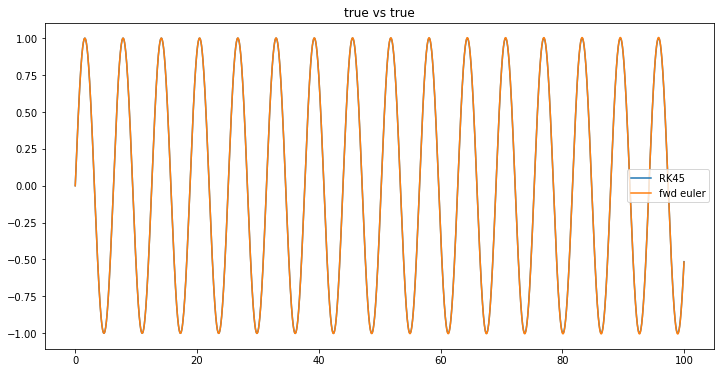

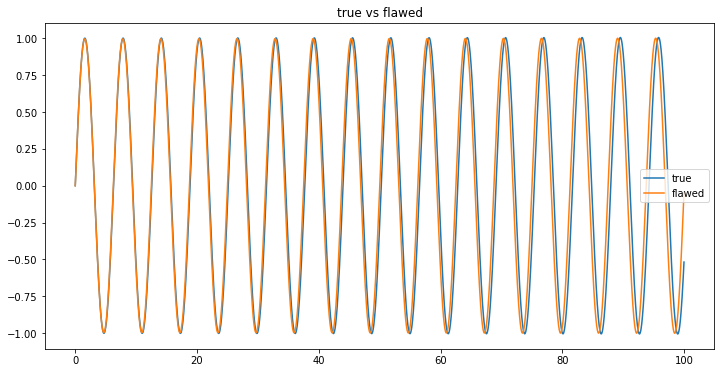

In [5]:
pts_to_show = 10000

fig, ax = plt.subplots(1, figsize=(12,6))
ax.plot(tt[:pts_to_show], RK45_true.y[0][:pts_to_show], label="RK45")
ax.plot(tt[:pts_to_show], euler_true.y[0][:pts_to_show], label="fwd euler")
ax.set_title("true vs true")
ax.legend()
plt.show()

fig, ax = plt.subplots(1, figsize=(12,6))
ax.plot(tt[:pts_to_show], sol_true.y[0][:pts_to_show], label="true")
ax.plot(tt[:pts_to_show], sol_flawed.y[0][:pts_to_show], label="flawed")
ax.set_title("true vs flawed")
ax.legend()
plt.show()

Model output function $\hat{\mathbf{y}}(t)=W_{out}^T\mathbf{h}(t)$ \
Know indices of bias, linear, and nonlinear components \
What we want is a gradient matrix $G=\nabla h(t)$ \
We can write the time derivative of the output as $\frac{d\hat{\mathbf{y}}(t)}{dt}=W_{out}^T\nabla h(t)\frac{\mathbf{h}_{lin}(t)}{dt}$ \
We will eventually train to minimize $\lVert\frac{d\mathbf{y}(t)}{dt}-\frac{d\hat{\mathbf{y}}(t)}{dt}\rVert^2$

e.g. for $k=2$, $s=1$, $d=2$

$$\mathbf{h}_{lin}(t)=\begin{bmatrix} x_1(t) \\ x_2(t) \\ x_1(t-\Delta t) \\ x_2(t-\Delta t)\end{bmatrix} \quad \mathbf{h}(t)=\begin{bmatrix} 1 \\ x_1(t) \\ x_2(t) \\ x_1(t-\Delta t) \\ x_2(t-\Delta t) \\ x_1(t)^2 \\ x_1(t)x_2(t) \\ x_1(t)x_1(t-\Delta t) \\ x_1(t)x_2(t-\Delta t) \\ x_2(t)^2 \\ x_2(t)x_1(t-\Delta t) \\  x_2(t)x_2(t-\Delta t) \\ x_1(t-\Delta t)^2 \\ x_1(t-\Delta t)x_2(t-\Delta t) \\ x_2(t-\Delta t)^2\end{bmatrix}$$

As a result, $\nabla \mathbf{h}(t)$ is given by

$$
\nabla\mathbf{h}_(t)=\begin{bmatrix}
0 & 0 & 0 & 0 \\
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 1 & 0 \\
0 & 0 & 0 & 1 \\
2x_1(t) & 0 & 0 & 0 \\
x_2(t) & x_1(t) & 0 & 0 \\
x_1(t-\Delta t) & 0 & x_1(t) & 0 \\
x_2(t-\Delta t) & 0 & 0 & x_1(t) \\
0 & 2x_2(t) & 0 & 0 \\
0 & x_1(t-\Delta t) & x_2(t) & 0 \\
0 & x_2(t-\Delta t) & 0 & x_2(t) \\
0 & 0 & 2x_1(t-\Delta t) & 0 \\
0 & 0 & x_2(t-\Delta t) & x_1(t-\Delta t) \\
0 & 0 & 0 & 2x_2(t-\Delta t)
 \end{bmatrix}$$

In [6]:
def basisVectRn(i,n):
    e = np.zeros(n)
    e[i] = 1
    return e

def getGradStateVector(h, k, d):
    h_dtype = h.dtype
    m = len(h)
    bias_indices = np.array([0])
    b = len(bias_indices)
    linear_indices = np.arange(b,1+k*d)
    l = len(linear_indices)
    nonlinear_indices = np.arange(b+l,b+l+int(k*d*(k*d + 1)/2))
    n = len(nonlinear_indices)
    linear = h[linear_indices]
    G = np.zeros((m, l)).astype(h_dtype)
    G[b:b+l] += np.eye(l)
    cumulative_ctr = b+l
    for i in range(l):
        G[cumulative_ctr:cumulative_ctr+(l-i),i:] += linear[i]*np.eye(l-i)
        G[cumulative_ctr:cumulative_ctr+(l-i),i] += linear[i:]
        cumulative_ctr += l-i
    return G

def d_hlin_dt(h, k, d, ODE):
    h_dtype = h.dtype
    m = len(h)
    bias_indices = np.array([0])
    b = len(bias_indices)
    linear_indices = np.arange(b,1+k*d)
    l = len(linear_indices)
    nonlinear_indices = np.arange(b+l,b+l+int(k*d*(k*d + 1)/2))
    n = len(nonlinear_indices)
    linear = h[linear_indices]
    out = np.zeros(l).astype(h_dtype)
    for i in range(k):
        out[i*d:(i+1)*d] = ODE(linear[i*d:(i+1)*d])
    return out

def d_yhat_dt(w, h, k, d, ODE):
    return w.T @ getGradStateVector(h, k, d) @ d_hlin_dt(h, k, d, ODE)

In [7]:
k=2
d=2

In [8]:
symb_state = get_symbolic_state_labels(
    k=k,
    d=d,
    nonlinearFunc = quadraticCombination,
    extraNonlinearFunc = None
)

In [9]:
symb_state

array([[1, 'bias'],
       [x(t)_1, 'linear'],
       [x(t)_2, 'linear'],
       [x(t-s)_1, 'linear'],
       [x(t-s)_2, 'linear'],
       [x(t)_1**2, 'nonlinear'],
       [x(t)_1*x(t)_2, 'nonlinear'],
       [x(t)_1*x(t-s)_1, 'nonlinear'],
       [x(t)_1*x(t-s)_2, 'nonlinear'],
       [x(t)_2**2, 'nonlinear'],
       [x(t)_2*x(t-s)_1, 'nonlinear'],
       [x(t)_2*x(t-s)_2, 'nonlinear'],
       [x(t-s)_1**2, 'nonlinear'],
       [x(t-s)_1*x(t-s)_2, 'nonlinear'],
       [x(t-s)_2**2, 'nonlinear']], dtype=object)

In [10]:
getGradStateVector(symb_state[:,0], k, d)

array([[0.0, 0.0, 0.0, 0.0],
       [1.0, 0.0, 0.0, 0.0],
       [0.0, 1.0, 0.0, 0.0],
       [0.0, 0.0, 1.0, 0.0],
       [0.0, 0.0, 0.0, 1.0],
       [2.0*x(t)_1, 0, 0, 0],
       [x(t)_2, 1.0*x(t)_1, 0, 0],
       [x(t-s)_1, 0, 1.0*x(t)_1, 0],
       [x(t-s)_2, 0, 0, 1.0*x(t)_1],
       [0.0, 2.0*x(t)_2, 0, 0],
       [0.0, x(t-s)_1, 1.0*x(t)_2, 0],
       [0.0, x(t-s)_2, 0, 1.0*x(t)_2],
       [0.0, 0.0, 2.0*x(t-s)_1, 0],
       [0.0, 0.0, x(t-s)_2, 1.0*x(t-s)_1],
       [0.0, 0.0, 0.0, 2.0*x(t-s)_2]], dtype=object)

In [11]:
d_hlin_dt(symb_state[:,0], k, d, dy_dt)

array([x(t)_2, -x(t)_1, x(t-s)_2, -x(t-s)_1], dtype=object)

In [12]:
true_data = sol_true.y.T
true_target = sol_true.y.T[1:]
flawed_data = sol_flawed.y.T
flawed_target = sol_flawed.y.T[1:]

k=2
# k=4
# k=8
# k=12
# k=16
# k=32

train_start=1000
train_end=11000
test_start=train_end
test_end=100000

training_target = true_target[train_start:train_end]
test_target = true_target[test_start:test_end]
train_indices = np.arange(train_start,train_end)
test_indices = np.arange(test_start,test_end)

train_indices.shape, test_indices.shape

((10000,), (89000,))

In [13]:
model = NVARModel(k=k, s=1, reg=1e-5, nonlinearFunc=quadraticCombination, natural_dt=dt) # k=4 -> 94 "units"
# model = NVARModel(k=k, s=4, reg=1e-5, nonlinearFunc=quadraticCombination, natural_dt=dt) # k=4 -> 94 "units"

In [14]:
model.train(
        true_data,
        true_target,
        # flawed_data,
        # flawed_target,
        train_indices,
        dataLossFactor=1,
        ODELossFactor=0,
        # ODEFunc=oneDSpring_ODE_wrapper(m=m_true,k=k_true,b=b_true,F=F_true),
        ODEFunc=oneDSpring_ODE_wrapper(m=m_flawed,k=k_flawed,b=b_flawed,F=F_flawed),
        printResults=True
        )

                    MSE     NMSE    NRMSE     Loss Weighted Loss
Component                                                       
Data           0.000000 0.000000 0.000000 0.000000      0.000000
ODE            0.000051 0.000050 0.479092 0.506723      0.000000
Regularization 0.033333 0.033333 0.182574 1.000001      0.000010
Total          0.033384 0.033383 0.661666 1.506724      0.000010


In [15]:
G = getGradStateVector(model.state[0], k, d)
dhlindt = d_hlin_dt(model.state[0], k, d, dy_dt)
G, dhlindt

(array([[ 0.        ,  0.        ,  0.        ,  0.        ],
        [ 1.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  1.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  1.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  1.        ],
        [-1.08858632,  0.        ,  0.        ,  0.        ],
        [-0.83949119, -0.54429316,  0.        ,  0.        ],
        [-0.53587091,  0.        , -0.54429316,  0.        ],
        [-0.84489163,  0.        ,  0.        , -0.54429316],
        [ 0.        , -1.67898238,  0.        ,  0.        ],
        [ 0.        , -0.53587091, -0.83949119,  0.        ],
        [ 0.        , -0.84489163,  0.        , -0.83949119],
        [ 0.        ,  0.        , -1.07174181,  0.        ],
        [ 0.        ,  0.        , -0.84489163, -0.53587091],
        [ 0.        ,  0.        ,  0.        , -1.68978326]]),
 array([-0.83949119,  0.54429316, -0.84489163,  0.53587091]))

In [16]:
model.w.T @ G @ dhlindt

array([-0.83400679,  0.55266099])

In [17]:
d_yhat_dt(model.w, model.state[0], k, d, dy_dt)

array([-0.83400679,  0.55266099])

In [18]:
dy_dt(true_target[train_start])

array([-0.83400679,  0.552661  ])

In [19]:
np.linalg.norm(model.w.T @ G @ dhlindt - dy_dt(true_target[train_start]))**2

9.951235355576978e-19

In [20]:
dYhat_dt = np.array([d_yhat_dt(model.w, model.state[i], k, d, dy_dt) for i in range(len(train_indices))])
dY_dt = np.array([dy_dt(true_target[i]) for i in train_indices])
err = np.array([np.linalg.norm(dYhat_dt[i]-dY_dt[i]) for i in range(len(train_indices))])
norm_dY_dt = np.array([np.linalg.norm(dY_dt[i]) for i in range(len(train_indices))])

In [21]:
np.average(err)

9.982808700835667e-10

In [22]:
err[:10]

array([9.97558788e-10, 9.97764750e-10, 9.97976096e-10, 9.98192269e-10, 9.98413898e-10, 9.98640233e-10, 9.98871112e-10, 9.99106418e-10, 9.99345783e-10, 9.99589910e-10])

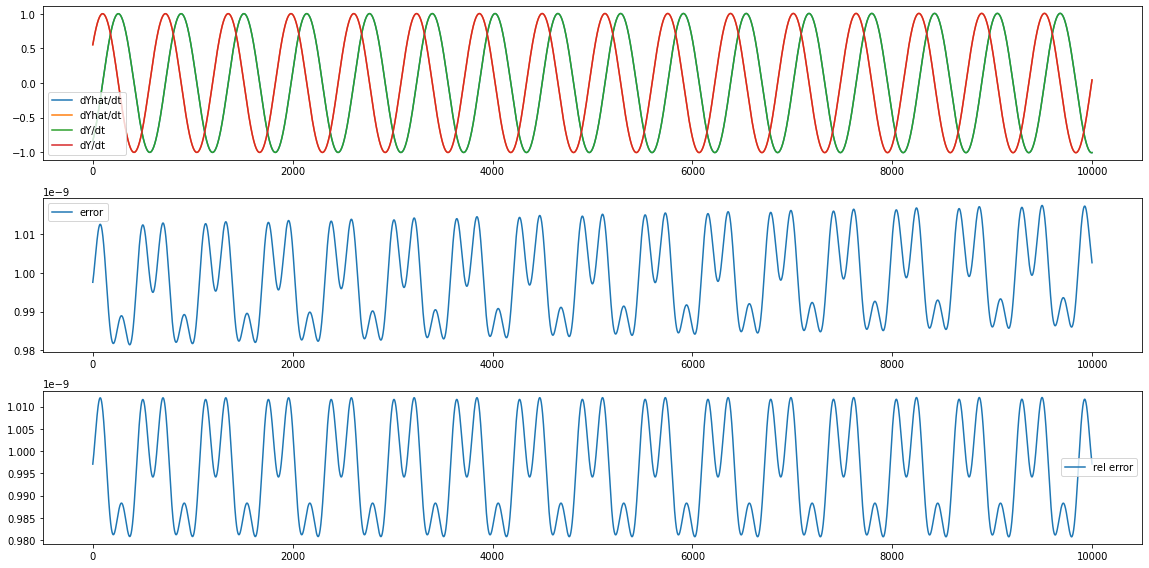

In [23]:
pts_to_show =10000
fig, axs = plt.subplots(3, figsize=(16,8))
axs[0].plot(dYhat_dt[:pts_to_show], label="dYhat/dt")
axs[0].plot(dY_dt[:pts_to_show], label="dY/dt")
axs[1].plot(err[:pts_to_show], label="error")
axs[2].plot(err[:pts_to_show]/norm_dY_dt[:pts_to_show], label="rel error")
axs[0].legend()
axs[1].legend()
axs[2].legend()
fig.tight_layout()
plt.show()

In [24]:
model.train(
        true_data,
        true_target,
        # flawed_data,
        # flawed_target,
        train_indices,
        dataLossFactor=0,
        ODELossFactor=1,
        ODEFunc=oneDSpring_ODE_wrapper(m=m_true,k=k_true,b=b_true,F=F_true),
        # ODEFunc=oneDSpring_ODE_wrapper(m=m_flawed,k=k_flawed,b=b_flawed,F=F_flawed),
        printResults=True
        )

                    MSE     NMSE    NRMSE     Loss Weighted Loss
Component                                                       
Data           0.000000 0.000000 0.010542 0.000028      0.000000
ODE            0.000000 0.000000 0.000000 0.000000      0.000000
Regularization 0.033334 0.033334 0.182577 1.000035      0.000010
Total          0.033334 0.033334 0.193119 1.000063      0.000010


In [25]:
dYhat_dt = np.array([d_yhat_dt(model.w, model.state[i], k, d, dy_dt) for i in range(len(train_indices))])
dY_dt = np.array([dy_dt(true_target[i]) for i in train_indices])
err = np.array([np.linalg.norm(dYhat_dt[i]-dY_dt[i]) for i in range(len(train_indices))])
norm_dY_dt = np.array([np.linalg.norm(dY_dt[i]) for i in range(len(train_indices))])

In [26]:
np.average(err)

5.2862264789249713e-05

In [27]:
err[:10]

array([5.27302329e-05, 5.27302594e-05, 5.27302860e-05, 5.27303125e-05, 5.27303391e-05, 5.27303656e-05, 5.27303922e-05, 5.27304187e-05, 5.27304452e-05, 5.27304718e-05])

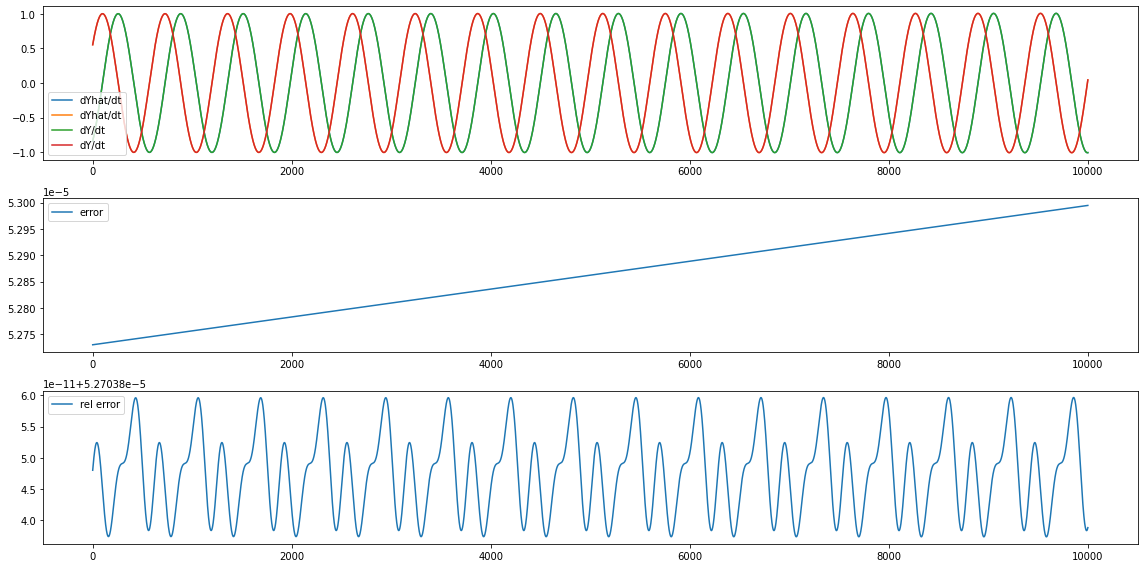

In [28]:
pts_to_show =10000
fig, axs = plt.subplots(3, figsize=(16,8))
axs[0].plot(dYhat_dt[:pts_to_show], label="dYhat/dt")
axs[0].plot(dY_dt[:pts_to_show], label="dY/dt")
axs[1].plot(err[:pts_to_show], label="error")
axs[2].plot(err[:pts_to_show]/norm_dY_dt[:pts_to_show], label="rel error")
axs[0].legend()
axs[1].legend()
axs[2].legend()
fig.tight_layout()
plt.show()

### Lorenz

In [29]:
T = 300
dt = 0.01
d = 3

lorenz = np.loadtxt(f'./datasets/py-lorenz_RK4_T={T}_dt={dt}.csv', delimiter=",", dtype='float64')

# c = 1/50
# feature_mean = lorenz[:,1:].mean(axis=0)
# target_mean = lorenz[1:,1:].mean(axis=0)

raw_data = lorenz[:,1:]
raw_target = lorenz[1:,1:]

data = raw_data
target = raw_target

# data = np.tanh((lorenz[:,1:]-feature_mean)*c)
# target = np.tanh((lorenz[1:,1:]-target_mean)*c)

k=4
# k=8
# k=12
# k=16

train_start=16500
train_end=24000
test_start=train_end
test_end=26000

training_target = target[train_start:train_end]
test_target = target[test_start:test_end]
train_indices = np.arange(train_start,train_end)
test_indices = np.arange(test_start,test_end)

In [30]:
dy_dt = simple_dlorenz()

In [31]:
model = NVARModel(k=k, s=2, reg=1e-5, nonlinearFunc=quadraticCombination, natural_dt=dt)

In [32]:
model.train(
        data,
        target,
        train_indices,
        dataLossFactor=1,
        ODELossFactor=0,
        ODEFunc=dy_dt,
        printResults=True
        )

                    MSE     NMSE    NRMSE        Loss Weighted Loss
Component                                                          
Data           0.000000 0.000000 0.000000    0.000000      0.000000
ODE            0.255632 0.000022 0.001416 1916.727466      0.000000
Regularization 0.003029 0.003029 0.055033    0.826829      0.000008
Total          0.258661 0.003051 0.056450 1917.554295      0.000009


In [33]:
dYhat_dt = np.array([d_yhat_dt(model.w, model.state[i], k, d, dy_dt) for i in range(len(train_indices))])
dY_dt = np.array([dy_dt(target[i]) for i in train_indices])
err = np.array([np.linalg.norm(dYhat_dt[i]-dY_dt[i]) for i in range(len(train_indices))])
norm_dY_dt = np.array([np.linalg.norm(dY_dt[i]) for i in range(len(train_indices))])

In [34]:
np.average(err)

0.0002123846194507537

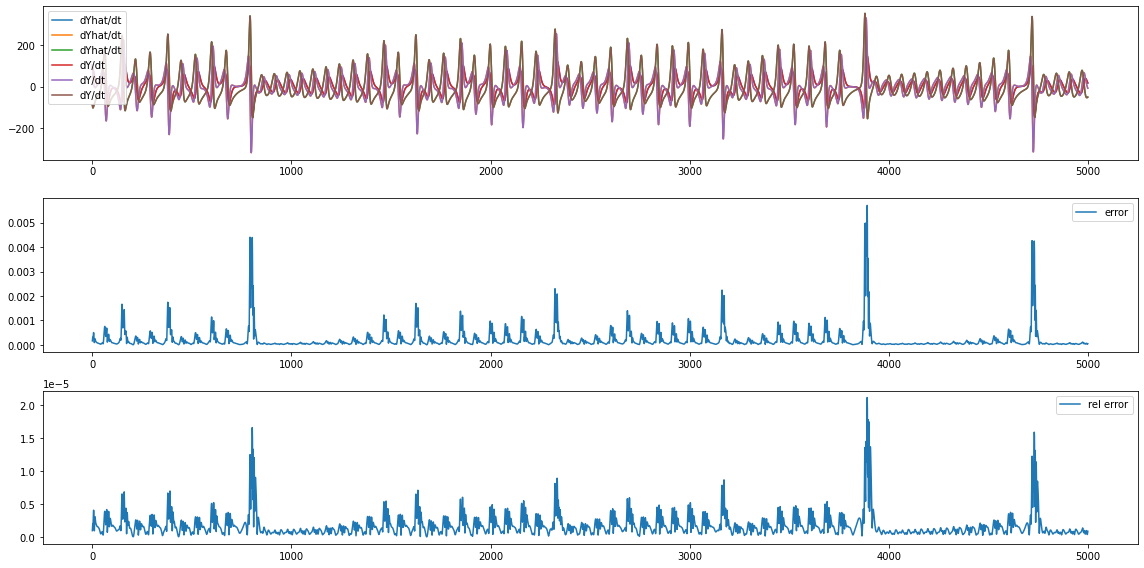

In [35]:
pts_to_show = 5000
fig, axs = plt.subplots(3, figsize=(16,8))
axs[0].plot(dYhat_dt[:pts_to_show], label="dYhat/dt")
axs[0].plot(dY_dt[:pts_to_show], label="dY/dt")
axs[1].plot(err[:pts_to_show], label="error")
axs[2].plot(err[:pts_to_show]/norm_dY_dt[:pts_to_show], label="rel error")
axs[0].legend()
axs[1].legend()
axs[2].legend()
fig.tight_layout()
plt.show()

In [36]:
model.train(
        data,
        target,
        train_indices,
        dataLossFactor=0,
        ODELossFactor=1,
        ODEFunc=dy_dt,
        printResults=True
        )

                    MSE     NMSE    NRMSE     Loss Weighted Loss
Component                                                       
Data           0.000613 0.000001 0.000540 4.598096      0.000000
ODE            0.000000 0.000000 0.000000 0.000151      0.000151
Regularization 0.003017 0.003017 0.054930 0.823733      0.000008
Total          0.003630 0.003018 0.055471 5.421980      0.000159


In [37]:
dYhat_dt = np.array([d_yhat_dt(model.w, model.state[i], k, d, dy_dt) for i in range(len(train_indices))])
dY_dt = np.array([dy_dt(target[i]) for i in train_indices])
err = np.array([np.linalg.norm(dYhat_dt[i]-dY_dt[i]) for i in range(len(train_indices))])
norm_dY_dt = np.array([np.linalg.norm(dY_dt[i]) for i in range(len(train_indices))])

In [38]:
np.average(err)

0.3002707970560777

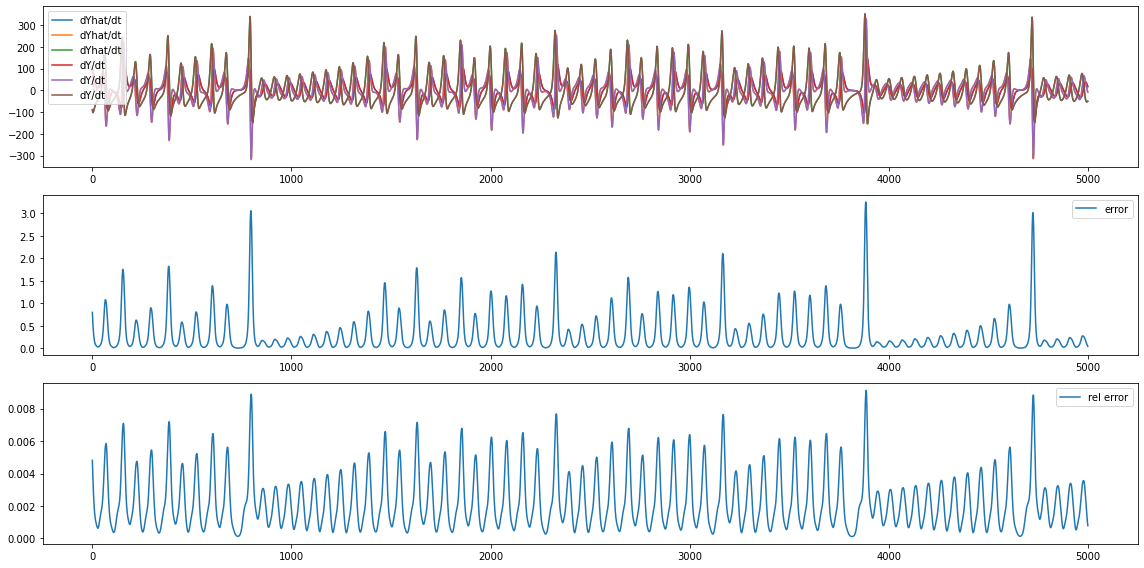

In [39]:
pts_to_show = 5000
fig, axs = plt.subplots(3, figsize=(16,8))
axs[0].plot(dYhat_dt[:pts_to_show], label="dYhat/dt")
axs[0].plot(dY_dt[:pts_to_show], label="dY/dt")
axs[1].plot(err[:pts_to_show], label="error")
axs[2].plot(err[:pts_to_show]/norm_dY_dt[:pts_to_show], label="rel error")
axs[0].legend()
axs[1].legend()
axs[2].legend()
fig.tight_layout()
plt.show()

In [40]:
k = 8

In [41]:
nvar_rows(3, k)

325

In [42]:
model = NVARModel(k=k, s=2, reg=1e-5, nonlinearFunc=quadraticCombination, natural_dt=dt)

In [43]:
model.train(
        data,
        target,
        train_indices,
        dataLossFactor=1,
        ODELossFactor=0,
        ODEFunc=dy_dt,
        printResults=True
        )

                    MSE     NMSE    NRMSE        Loss Weighted Loss
Component                                                          
Data           0.000000 0.000000 0.000000    0.000000      0.000000
ODE            0.255631 0.000022 0.001416 1916.721477      0.000000
Regularization 0.000596 0.000596 0.024421    0.581489      0.000006
Total          0.256227 0.000618 0.025837 1917.302966      0.000006


In [44]:
dYhat_dt = np.array([d_yhat_dt(model.w, model.state[i], k, d, dy_dt) for i in range(len(train_indices))])
dY_dt = np.array([dy_dt(target[i]) for i in train_indices])
err = np.array([np.linalg.norm(dYhat_dt[i]-dY_dt[i]) for i in range(len(train_indices))])
norm_dY_dt = np.array([np.linalg.norm(dY_dt[i]) for i in range(len(train_indices))])

In [45]:
np.average(err)

0.0002965278921138338

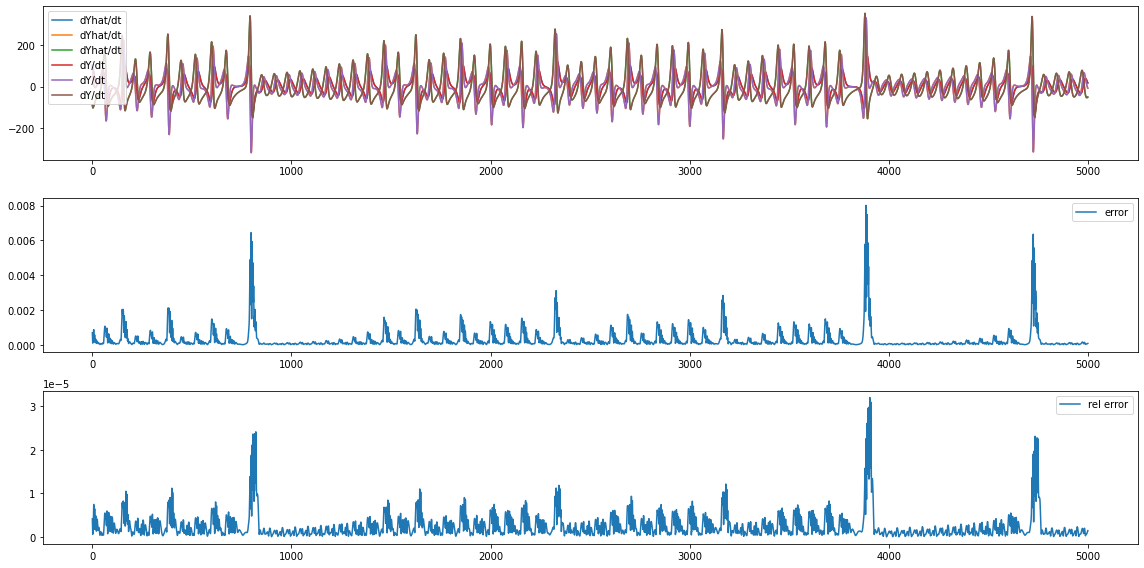

In [46]:
pts_to_show = 5000
fig, axs = plt.subplots(3, figsize=(16,8))
axs[0].plot(dYhat_dt[:pts_to_show], label="dYhat/dt")
axs[0].plot(dY_dt[:pts_to_show], label="dY/dt")
axs[1].plot(err[:pts_to_show], label="error")
axs[2].plot(err[:pts_to_show]/norm_dY_dt[:pts_to_show], label="rel error")
axs[0].legend()
axs[1].legend()
axs[2].legend()
fig.tight_layout()
plt.show()

In [47]:
model.train(
        data,
        target,
        train_indices,
        dataLossFactor=0,
        ODELossFactor=1,
        ODEFunc=dy_dt,
        printResults=True
        )

                    MSE     NMSE    NRMSE     Loss Weighted Loss
Component                                                       
Data           0.000613 0.000001 0.000540 4.598097      0.000000
ODE            0.000000 0.000000 0.000000 0.000142      0.000142
Regularization 0.000594 0.000594 0.024372 0.579166      0.000006
Total          0.001207 0.000595 0.024913 5.177405      0.000148


In [48]:
dYhat_dt = np.array([d_yhat_dt(model.w, model.state[i], k, d, dy_dt) for i in range(len(train_indices))])
# dY_dt = np.array([dy_dt(data[i]) for i in train_indices])
dY_dt = np.array([dy_dt(target[i]) for i in train_indices])
err = np.array([np.linalg.norm(dYhat_dt[i]-dY_dt[i]) for i in range(len(train_indices))])
norm_dY_dt = np.array([np.linalg.norm(dY_dt[i]) for i in range(len(train_indices))])

In [49]:
np.average(err)

0.30025463419921383

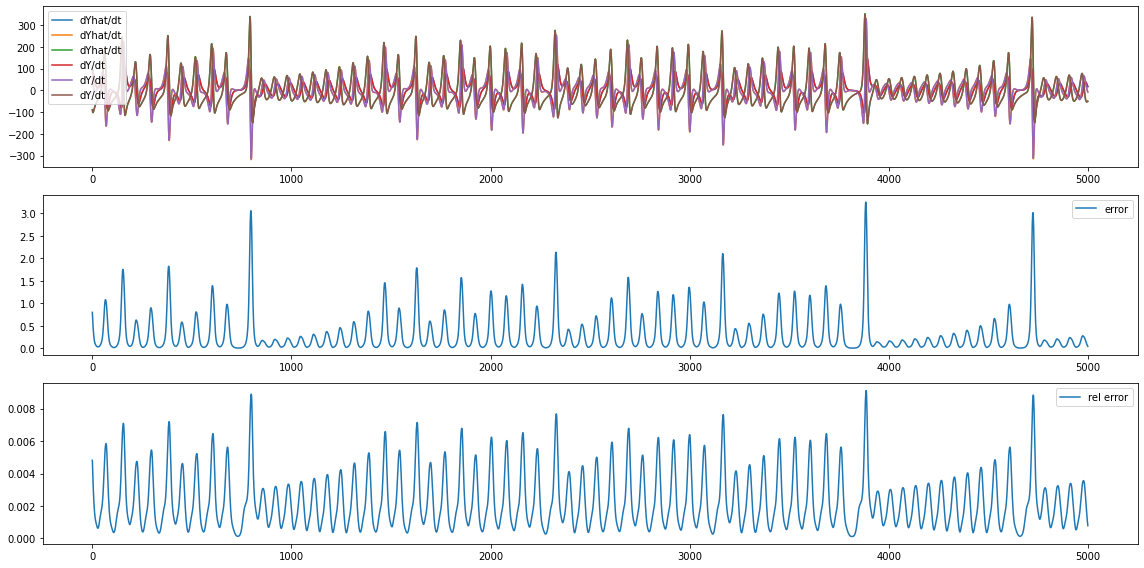

In [50]:
pts_to_show = 5000
fig, axs = plt.subplots(3, figsize=(16,8))
axs[0].plot(dYhat_dt[:pts_to_show], label="dYhat/dt")
axs[0].plot(dY_dt[:pts_to_show], label="dY/dt")
axs[1].plot(err[:pts_to_show], label="error")
axs[2].plot(err[:pts_to_show]/norm_dY_dt[:pts_to_show], label="rel error")
axs[0].legend()
axs[1].legend()
axs[2].legend()
fig.tight_layout()
plt.show()

In [52]:
model.state.shape

(7500, 325)